In [1]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [2]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
# And more imports for our NLP related machine learning

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess

In [4]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier

In [5]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [6]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [7]:
%matplotlib inline

In [8]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

train = [item for item in train if item.prompt]

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

test = [item for item in test if item.prompt]

In [9]:
# Sample of training prompt

print(train[0].prompt)

What is the financial sentiment of this tweet?

$BYND - JPMorgan reels in expectations on Beyond Meat https

Sentiment is bearish


In [10]:
# Sample of training label

print(train[0].label_category)

bearish


In [11]:
# Tester Function for Categorical Predictions
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.label   # assuming `label` is the categorical ground truth
        self.guesses.append(guess)
        self.truths.append(truth)
        title = datapoint.text if len(datapoint.text) <= 40 else datapoint.text[:40]+"..."
        print(f"{i+1}: Guess={guess} Truth={truth} Item: {title}")

    def chart_confusion_matrix(self):
        cm = confusion_matrix(self.truths, self.guesses, labels=[0,1,2])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"{self.title} - Confusion Matrix")
        plt.show()

    def report(self):
        acc = accuracy_score(self.truths, self.guesses)
        precision, recall, f1, _ = precision_recall_fscore_support(self.truths, self.guesses, average="weighted")
        
        print(f"\n===== {self.title} Report =====")
        print(f"Accuracy: {acc:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")
        
        self.chart_confusion_matrix()

    def run(self):
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

1: Guess=2 Truth=0 Item: $DELL $HPE - Dell, HPE targets trimmed o...
2: Guess=0 Truth=0 Item: $PRTY - Moody's turns negative on Party ...
3: Guess=0 Truth=0 Item: $TAP - Barclays cools on Molson Coors ht...
4: Guess=2 Truth=0 Item: Analysts Eviscerate Musk's Cybertruck: "...
5: Guess=1 Truth=0 Item: Barclays assigns only a 20% chance that ...
6: Guess=0 Truth=0 Item: BTIG points to breakfast pressure for Du...
7: Guess=0 Truth=0 Item: Children's Place downgraded to neutral f...
8: Guess=0 Truth=0 Item: Clovis Oncology downgraded to in line fr...
9: Guess=2 Truth=0 Item: Downgrades 4/7: $AAN $BDN $BECN $BTE $CD...
10: Guess=0 Truth=0 Item: Goldman pulls Progressive from Goldman's...
11: Guess=2 Truth=0 Item: Hanesbrands downgraded to underperform v...
12: Guess=2 Truth=0 Item: LendingTree price target cut to $350 fro...
13: Guess=2 Truth=0 Item: Mizuho cuts XLNX target on near-term hea...
14: Guess=0 Truth=0 Item: MPLX cut at Credit Suisse on potential d...
15: Guess=2 Truth=0 Item: Nor

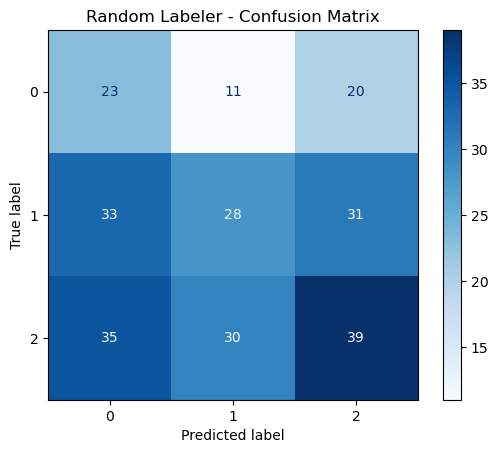

In [12]:
# Model 1: Random labeler
def random_labeler(item):
    return random.randrange(0,3)

# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_labeler)

/opt/anaconda3/envs/llms/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1: Guess=0 Truth=0 Item: $DELL $HPE - Dell, HPE targets trimmed o...
2: Guess=0 Truth=0 Item: $PRTY - Moody's turns negative on Party ...
3: Guess=0 Truth=0 Item: $TAP - Barclays cools on Molson Coors ht...
4: Guess=0 Truth=0 Item: Analysts Eviscerate Musk's Cybertruck: "...
5: Guess=0 Truth=0 Item: Barclays assigns only a 20% chance that ...
6: Guess=0 Truth=0 Item: BTIG points to breakfast pressure for Du...
7: Guess=0 Truth=0 Item: Children's Place downgraded to neutral f...
8: Guess=0 Truth=0 Item: Clovis Oncology downgraded to in line fr...
9: Guess=0 Truth=0 Item: Downgrades 4/7: $AAN $BDN $BECN $BTE $CD...
10: Guess=0 Truth=0 Item: Goldman pulls Progressive from Goldman's...
11: Guess=0 Truth=0 Item: Hanesbrands downgraded to underperform v...
12: Guess=0 Truth=0 Item: LendingTree price target cut to $350 fro...
13: Guess=0 Truth=0 Item: Mizuho cuts XLNX target on near-term hea...
14: Guess=0 Truth=0 Item: MPLX cut at Credit Suisse on potential d...
15: Guess=0 Truth=0 Item: Nor

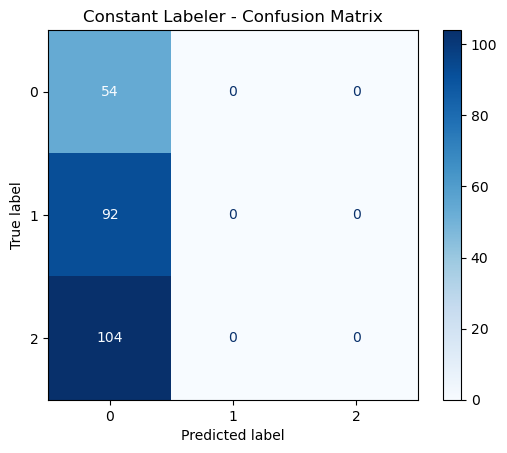

In [13]:
# Model 2: constant labeler
def constant_labeler(item):
    return 0

# Run our constant predictor
Tester.test(constant_labeler)

In [14]:
# Prepare documents and labels for next few models
labels = np.array([float(item.label) for item in train if item.prompt])
documents = [item.test_prompt() for item in train if item.prompt]

1: Guess=2.0 Truth=0 Item: $DELL $HPE - Dell, HPE targets trimmed o...
2: Guess=2.0 Truth=0 Item: $PRTY - Moody's turns negative on Party ...
3: Guess=2.0 Truth=0 Item: $TAP - Barclays cools on Molson Coors ht...
4: Guess=1.0 Truth=0 Item: Analysts Eviscerate Musk's Cybertruck: "...
5: Guess=2.0 Truth=0 Item: Barclays assigns only a 20% chance that ...
6: Guess=1.0 Truth=0 Item: BTIG points to breakfast pressure for Du...
7: Guess=0.0 Truth=0 Item: Children's Place downgraded to neutral f...
8: Guess=0.0 Truth=0 Item: Clovis Oncology downgraded to in line fr...
9: Guess=2.0 Truth=0 Item: Downgrades 4/7: $AAN $BDN $BECN $BTE $CD...
10: Guess=0.0 Truth=0 Item: Goldman pulls Progressive from Goldman's...
11: Guess=0.0 Truth=0 Item: Hanesbrands downgraded to underperform v...
12: Guess=0.0 Truth=0 Item: LendingTree price target cut to $350 fro...
13: Guess=0.0 Truth=0 Item: Mizuho cuts XLNX target on near-term hea...
14: Guess=2.0 Truth=0 Item: MPLX cut at Credit Suisse on potential d...
1

/opt/anaconda3/envs/llms/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


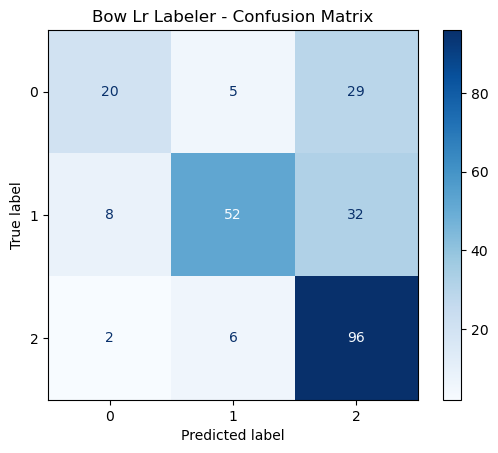

In [15]:
# Model 3: Bag of words model with count vectorizer

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)

# Train classifier
classifier = LogisticRegression(max_iter=1000, multi_class='multinomial')
classifier.fit(X, labels)

def bow_lr_labeler(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(classifier.predict(x)[0], 0)

# test it
Tester.test(bow_lr_labeler)

1: Guess=1.0 Truth=0 Item: $DELL $HPE - Dell, HPE targets trimmed o...
2: Guess=1.0 Truth=0 Item: $PRTY - Moody's turns negative on Party ...
3: Guess=1.0 Truth=0 Item: $TAP - Barclays cools on Molson Coors ht...
4: Guess=1.0 Truth=0 Item: Analysts Eviscerate Musk's Cybertruck: "...
5: Guess=1.0 Truth=0 Item: Barclays assigns only a 20% chance that ...
6: Guess=1.0 Truth=0 Item: BTIG points to breakfast pressure for Du...
7: Guess=1.0 Truth=0 Item: Children's Place downgraded to neutral f...
8: Guess=1.0 Truth=0 Item: Clovis Oncology downgraded to in line fr...
9: Guess=1.0 Truth=0 Item: Downgrades 4/7: $AAN $BDN $BECN $BTE $CD...
10: Guess=1.0 Truth=0 Item: Goldman pulls Progressive from Goldman's...
11: Guess=1.0 Truth=0 Item: Hanesbrands downgraded to underperform v...
12: Guess=1.0 Truth=0 Item: LendingTree price target cut to $350 fro...
13: Guess=1.0 Truth=0 Item: Mizuho cuts XLNX target on near-term hea...
14: Guess=1.0 Truth=0 Item: MPLX cut at Credit Suisse on potential d...
1

/opt/anaconda3/envs/llms/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/llms/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


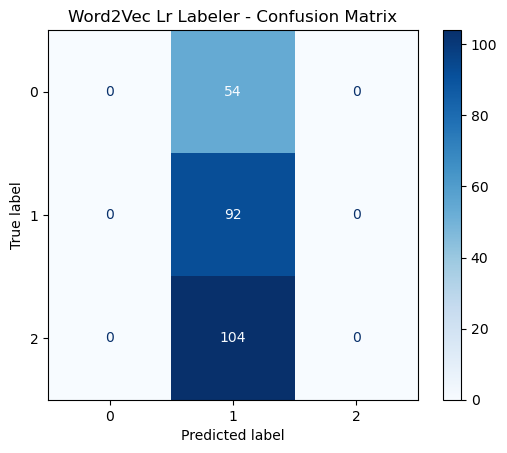

In [16]:
# Model 4: Logistic regression with word2vec model
np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

# This step of averaging vectors across the document is a weakness in our approach

# Create document vectors by averaging word embeddings
def document_vector(doc):
    doc = [word for word in doc if word in w2v_model.wv.key_to_index]
    if len(doc) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(w2v_model.wv[doc], axis=0)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

# Run Linear Regression on word2vec

word2vec_lr_classifier = LogisticRegression(max_iter=2000, multi_class='multinomial', solver="saga",class_weight="balanced",)
word2vec_lr_classifier.fit(X_w2v, labels)

def word2vec_lr_labeler(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_classifier.predict([doc_vector])[0])

Tester.test(word2vec_lr_labeler)

1: Guess=2.0 Truth=0 Item: $DELL $HPE - Dell, HPE targets trimmed o...
2: Guess=2.0 Truth=0 Item: $PRTY - Moody's turns negative on Party ...
3: Guess=2.0 Truth=0 Item: $TAP - Barclays cools on Molson Coors ht...
4: Guess=2.0 Truth=0 Item: Analysts Eviscerate Musk's Cybertruck: "...
5: Guess=2.0 Truth=0 Item: Barclays assigns only a 20% chance that ...
6: Guess=2.0 Truth=0 Item: BTIG points to breakfast pressure for Du...
7: Guess=2.0 Truth=0 Item: Children's Place downgraded to neutral f...
8: Guess=2.0 Truth=0 Item: Clovis Oncology downgraded to in line fr...
9: Guess=2.0 Truth=0 Item: Downgrades 4/7: $AAN $BDN $BECN $BTE $CD...
10: Guess=2.0 Truth=0 Item: Goldman pulls Progressive from Goldman's...
11: Guess=2.0 Truth=0 Item: Hanesbrands downgraded to underperform v...
12: Guess=2.0 Truth=0 Item: LendingTree price target cut to $350 fro...
13: Guess=2.0 Truth=0 Item: Mizuho cuts XLNX target on near-term hea...
14: Guess=2.0 Truth=0 Item: MPLX cut at Credit Suisse on potential d...
1

/opt/anaconda3/envs/llms/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


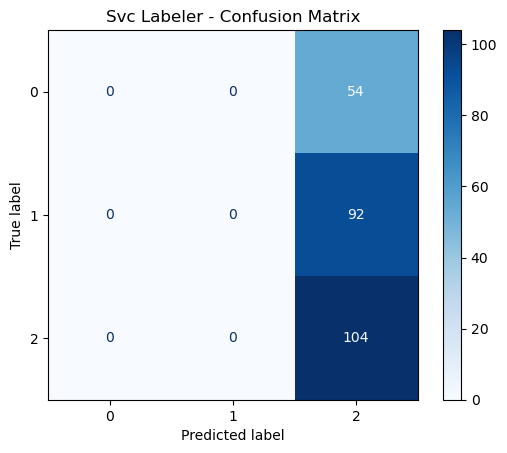

In [17]:
# Model 5: SVC with word2vec model
np.random.seed(42)

# Train classifier
svc_classifier = LinearSVC(random_state=42)

svc_classifier.fit(X_w2v, labels)

def svc_labeler(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svc_classifier.predict([doc_vector])[0]),0)

Tester.test(svc_labeler)

1: Guess=2 Truth=0 Item: $DELL $HPE - Dell, HPE targets trimmed o...
2: Guess=2 Truth=0 Item: $PRTY - Moody's turns negative on Party ...
3: Guess=2 Truth=0 Item: $TAP - Barclays cools on Molson Coors ht...
4: Guess=2 Truth=0 Item: Analysts Eviscerate Musk's Cybertruck: "...
5: Guess=2 Truth=0 Item: Barclays assigns only a 20% chance that ...
6: Guess=2 Truth=0 Item: BTIG points to breakfast pressure for Du...
7: Guess=2 Truth=0 Item: Children's Place downgraded to neutral f...
8: Guess=0 Truth=0 Item: Clovis Oncology downgraded to in line fr...
9: Guess=2 Truth=0 Item: Downgrades 4/7: $AAN $BDN $BECN $BTE $CD...
10: Guess=2 Truth=0 Item: Goldman pulls Progressive from Goldman's...
11: Guess=0 Truth=0 Item: Hanesbrands downgraded to underperform v...
12: Guess=1 Truth=0 Item: LendingTree price target cut to $350 fro...
13: Guess=2 Truth=0 Item: Mizuho cuts XLNX target on near-term hea...
14: Guess=0 Truth=0 Item: MPLX cut at Credit Suisse on potential d...
15: Guess=2 Truth=0 Item: Nor

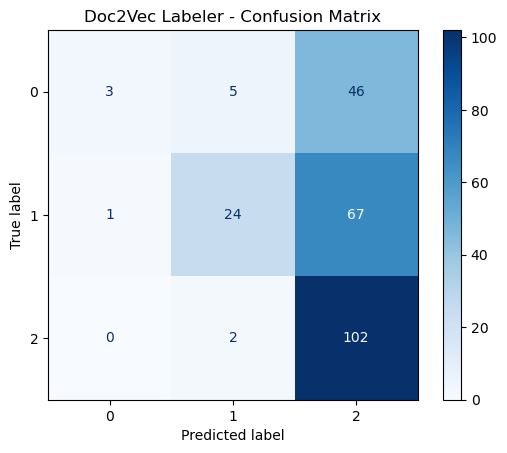

In [18]:
# Model 6: RandomForestClassifier with doc2vec model

# -------------------------
# 1. Preprocess documents
# -------------------------
processed_docs = [simple_preprocess(doc) for doc in documents]

# -------------------------
# 2. Tag documents for Doc2Vec
# -------------------------
tagged_docs = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(processed_docs)]

# -------------------------
# 3. Train Doc2Vec model
# -------------------------
doc2vec_model = Doc2Vec(
    vector_size=400,
    window=5,
    min_count=1,
    workers=8,
    epochs=50,
    seed=42
)
doc2vec_model.build_vocab(tagged_docs)
doc2vec_model.train(tagged_docs, total_examples=len(tagged_docs), epochs=50)

# -------------------------
# 4. Build document vectors
# -------------------------
X_doc2vec = np.array([doc2vec_model.infer_vector(doc) for doc in processed_docs])
y = np.array(labels)

# -------------------------
# 5. Random oversampling for class balance
# -------------------------
# Separate by class
X_0 = X_doc2vec[y == 0]
X_1 = X_doc2vec[y == 1]
X_2 = X_doc2vec[y == 2]

y_0 = y[y == 0]
y_1 = y[y == 1]
y_2 = y[y == 2]

# Upsample minority classes
X_0_up, y_0_up = resample(X_0, y_0, replace=True, n_samples=len(y_2), random_state=42)
X_1_up, y_1_up = resample(X_1, y_1, replace=True, n_samples=len(y_2), random_state=42)

# Combine with majority class
X_bal = np.vstack([X_2, X_0_up, X_1_up])
y_bal = np.hstack([y_2, y_0_up, y_1_up])

# Shuffle
shuffle_idx = np.random.permutation(len(y_bal))
X_bal = X_bal[shuffle_idx]
y_bal = y_bal[shuffle_idx]

# -------------------------
# 6. Train RandomForestClassifier
# -------------------------
clf = RandomForestClassifier(random_state=42)
clf.fit(X_bal, y_bal)

# -------------------------
# 7. Prediction wrapper for Tester
# -------------------------
def doc2vec_labeler(item):
    doc = item.test_prompt()
    doc_vector = doc2vec_model.infer_vector(simple_preprocess(doc))
    return int(clf.predict([doc_vector])[0])

# -------------------------
# 8. Run Tester
# -------------------------
Tester.test(doc2vec_labeler)


1: Guess=0 Truth=0 Item: $DELL $HPE - Dell, HPE targets trimmed o...
2: Guess=0 Truth=0 Item: $PRTY - Moody's turns negative on Party ...
3: Guess=2 Truth=0 Item: $TAP - Barclays cools on Molson Coors ht...
4: Guess=1 Truth=0 Item: Analysts Eviscerate Musk's Cybertruck: "...
5: Guess=1 Truth=0 Item: Barclays assigns only a 20% chance that ...
6: Guess=1 Truth=0 Item: BTIG points to breakfast pressure for Du...
7: Guess=0 Truth=0 Item: Children's Place downgraded to neutral f...
8: Guess=0 Truth=0 Item: Clovis Oncology downgraded to in line fr...
9: Guess=0 Truth=0 Item: Downgrades 4/7: $AAN $BDN $BECN $BTE $CD...
10: Guess=1 Truth=0 Item: Goldman pulls Progressive from Goldman's...
11: Guess=0 Truth=0 Item: Hanesbrands downgraded to underperform v...
12: Guess=1 Truth=0 Item: LendingTree price target cut to $350 fro...
13: Guess=0 Truth=0 Item: Mizuho cuts XLNX target on near-term hea...
14: Guess=0 Truth=0 Item: MPLX cut at Credit Suisse on potential d...
15: Guess=0 Truth=0 Item: Nor

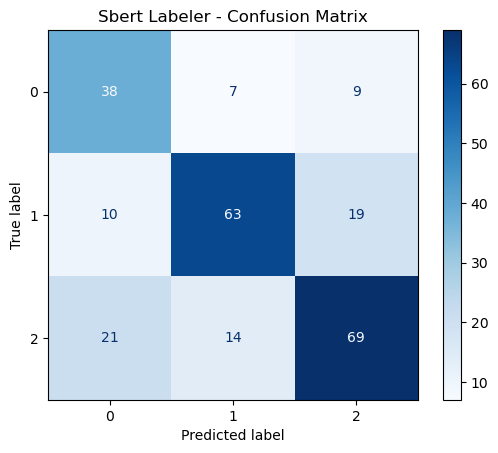

In [19]:
# Model 7: MLPClassifier with SBERT embeddings
# -------------------------
# 1. Pretrained SBERT embeddings
# -------------------------
model = SentenceTransformer('all-MiniLM-L6-v2')
X_embeddings = model.encode(documents)  # shape: (n_samples, embedding_dim)
y = np.array(labels)

# -------------------------
# 2. Stratified train/test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_embeddings, y, test_size=0.2, stratify=y, random_state=42
)

# -------------------------
# 3. Random oversampling on training set
# -------------------------
# Separate by class
X_0 = X_train[y_train == 0]
X_1 = X_train[y_train == 1]
X_2 = X_train[y_train == 2]

y_0 = y_train[y_train == 0]
y_1 = y_train[y_train == 1]
y_2 = y_train[y_train == 2]

# Upsample minority classes to match majority class
max_samples = max(len(y_0), len(y_1), len(y_2))
X_0_up, y_0_up = resample(X_0, y_0, replace=True, n_samples=max_samples, random_state=42)
X_1_up, y_1_up = resample(X_1, y_1, replace=True, n_samples=max_samples, random_state=42)
X_2_up, y_2_up = resample(X_2, y_2, replace=True, n_samples=max_samples, random_state=42)

# Combine and shuffle
X_train_bal = np.vstack([X_0_up, X_1_up, X_2_up])
y_train_bal = np.hstack([y_0_up, y_1_up, y_2_up])
shuffle_idx = np.random.permutation(len(y_train_bal))
X_train_bal = X_train_bal[shuffle_idx]
y_train_bal = y_train_bal[shuffle_idx]

# -------------------------
# 4. Train MLPClassifier
# -------------------------
clf = MLPClassifier(hidden_layer_sizes=(256,128), max_iter=500, random_state=42)
clf.fit(X_train_bal, y_train_bal)

# -------------------------
# 6. Prediction wrapper for Tester
# -------------------------
def sbert_labeler(item):
    doc = item.test_prompt()
    doc_vector = model.encode([doc])  # SBERT embedding
    return int(clf.predict(doc_vector)[0])

# -------------------------
# 7. Run Tester
# -------------------------
Tester.test(sbert_labeler)
